## Libraries

In [73]:
# libraries
import numpy as np
import sys
sys.path.append("../backend/")
%matplotlib inline
import matplotlib.pylab as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# EMUstack
import objects
import materials
import plotting
from stack import *

# importing py-matrix parent folder
sys.path.append('/home/giovi/electrodynamics/st-matrix')
import py_matrix as pm


#parallel computation
from multiprocessing import cpu_count
from joblib import Parallel, delayed
num_cores = cpu_count() # number of threads -> usually equal to number of cores

## EMUstack

In [74]:
# light parameters
wl_1 = 8000
wl_2 = 16000
n_wl = 64

# Set up light objects
wavelengths = np.linspace(wl_1,wl_2, n_wl)
light_list  = [objects.Light(wl, max_order_PWs = 1,theta=0.0,phi=0.0) for wl in wavelengths]

# nanodisk array r and pitch in nm
nd_r = 1000
nd_d = 12000
nd_h = 1000

# defining the layers: period must be consistent throughout simulation!!!
NHs = objects.NanoStruct('2D_array', nd_d, 2.0*nd_r, height_nm = nd_h,period_y=0.5*nd_d,
    inclusion_a = materials.Ge_Doped, background = materials.Air, loss = True,
    inc_shape='circle',
    plotting_fields=True,plot_real=1,
    make_mesh_now = True, force_mesh = True, lc_bkg = 0.25, lc2= 6.0, lc3= 6.0,plt_msh=True)#lc_bkg = 0.08, lc2= 5.0)

superstrate = objects.ThinFilm(period = nd_d, height_nm = 'semi_inf',
    material = materials.Air, loss = False)
substrate   = objects.ThinFilm(period = nd_d, height_nm = 'semi_inf',
    material = materials.Air, loss = False)

In [75]:
# EMUstack Function
def simulate_stack(light):

    # evaluate each layer individually 
    sim_NHs          = NHs.calc_modes(light)
    sim_superstrate  = superstrate.calc_modes(light)
    sim_substrate    = substrate.calc_modes(light)

    # build the stack solution
    stackSub = Stack((sim_substrate, sim_NHs, sim_superstrate))
    stackSub.calc_scat(pol = 'TM')

    return stackSub

In [76]:
%%time
# computation
stacks_list=Parallel(n_jobs=num_cores)(delayed(simulate_stack)(light) for light in light_list)

CPU times: user 2.48 s, sys: 6.43 s, total: 8.9 s
Wall time: 16.4 s


# EMUstack Spectra plot

In [77]:
# spectra
a_list = []
t_list = []
r_list = []
for stack in stacks_list:
    a_list.extend(stack.a_list)
    t_list.extend(stack.t_list)
    r_list.extend(stack.r_list)
layers_steps = len(stacks_list[0].layers) - 1
a_tot      = []
t_tot      = []
r_tot      = []
for i in range(len(wavelengths)):
    a_tot.append(float(a_list[layers_steps-1+(i*layers_steps)]))
    t_tot.append(float(t_list[layers_steps-1+(i*layers_steps)]))
    r_tot.append(float(r_list[i]))

In [78]:
s4_data = np.loadtxt('/home/giovi/electrodynamics/st-matrix/EMUstack/examples/s4_issue_8.spt')

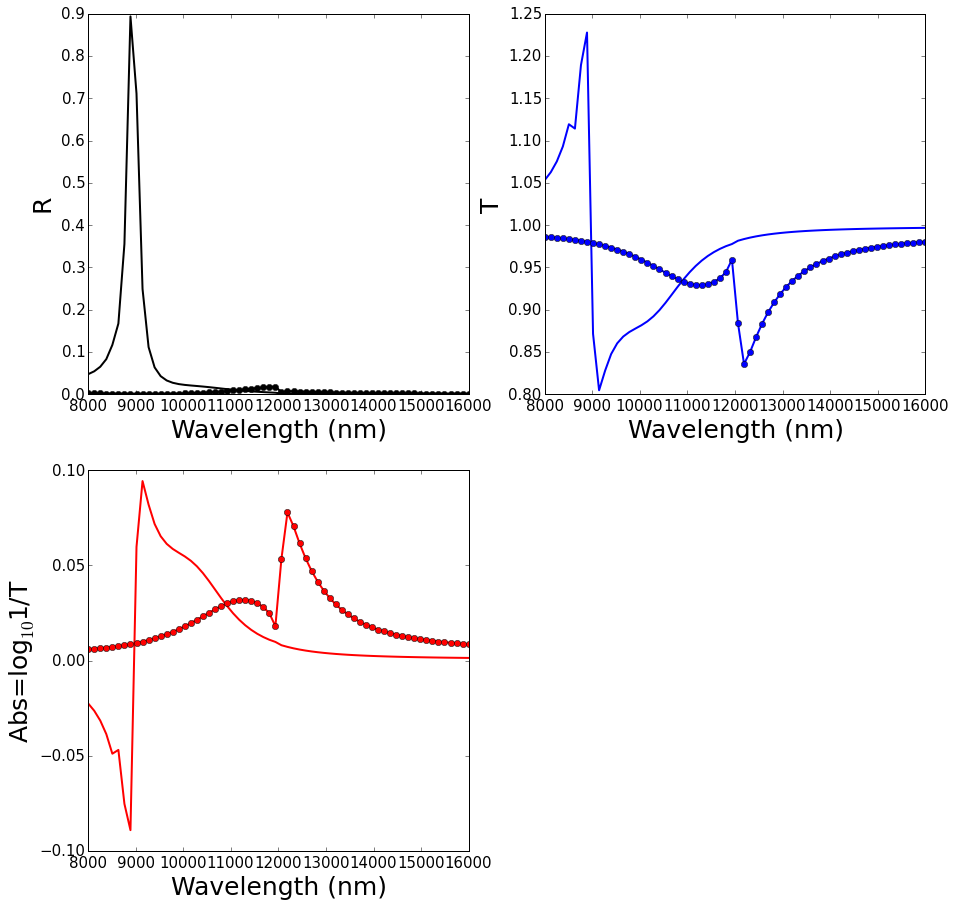

In [79]:
# R, T and abs spectra
plt.figure(figsize=(15,15))


plt.subplot(2,2,1)
plt.plot(wavelengths,np.array(r_tot),'k',
         s4_data[:,0],s4_data[:,1],'ko-',
         linewidth = 2.0);
f_size=25;

# labels
plt.xlabel("Wavelength (nm)",fontsize = f_size);
plt.ylabel("R",fontsize = f_size);

# ticks
plt.xticks(fontsize=f_size-10);
plt.yticks(fontsize=f_size-10);

plt.subplot(2,2,2)
plt.plot(wavelengths,np.array(t_tot),'b',
         s4_data[:,0],s4_data[:,2],'bo-',
         linewidth = 2.0);
f_size=25;

# labels
plt.xlabel("Wavelength (nm)",fontsize = f_size);
plt.ylabel("T",fontsize = f_size);

# ticks
plt.xticks(fontsize=f_size-10);
plt.yticks(fontsize=f_size-10);

plt.subplot(2,2,3)
plt.plot(wavelengths,np.log10(1.0/np.array(t_tot)),'r',
         s4_data[:,0],np.log10(1.0/np.array(s4_data[:,2])),'ro-',
         linewidth = 2.0);
f_size=25;

# labels
plt.xlabel("Wavelength (nm)",fontsize = f_size);
plt.ylabel(r"Abs=log$_{10}$1/T",fontsize = f_size);

# ticks
plt.xticks(fontsize=f_size-10);
plt.yticks(fontsize=f_size-10);

# EMUstack Triangulation field plot

In [80]:
# triangular interpolation computation
ReEx,ImEx,ReEy,ImEy,ReEz,ImEz,AbsE = plotting.fields_interpolator_in_plane(stacks_list[np.array(s4_data[:,1]).argmin()],lay_interest=1,z_value=0.90*nd_h)
# ReEx,ImEx,ReEy,ImEy,ReEz,ImEz,AbsE = plotting.fields_interpolator_in_plane(stacks_list[31],lay_interest=1,z_value=0.50*nd_h)
# field mapping
n_points=250
v_x=np.zeros(n_points**2)
v_y=np.zeros(n_points**2)
i=0
x_min=0.0;x_max=1.0
y_min=-1.0;y_max=0.0
for x in np.linspace(x_min,x_max,n_points):
    for y in np.linspace(y_min,y_max,n_points):
        v_x[i] = x
        v_y[i] = y
        i+=1
v_x = np.array(v_x)
v_y = np.array(v_y)

# interpolated fields
m_ReEx = ReEx(v_x,v_y).reshape(n_points,n_points)
m_ReEy = ReEy(v_x,v_y).reshape(n_points,n_points)
m_ReEz = ReEz(v_x,v_y).reshape(n_points,n_points)
m_ImEx = ImEx(v_x,v_y).reshape(n_points,n_points)
m_ImEy = ImEy(v_x,v_y).reshape(n_points,n_points)
m_ImEz = ImEz(v_x,v_y).reshape(n_points,n_points)
m_AbsE = AbsE(v_x,v_y).reshape(n_points,n_points)
v_plots = [m_ReEx,m_ReEy,m_ReEz,m_ImEx,m_ImEy,m_ImEz,m_AbsE]
v_labels = ["ReEx","ReEy","ReEz","ImEx","ImEy","ImEz","AbsE"]

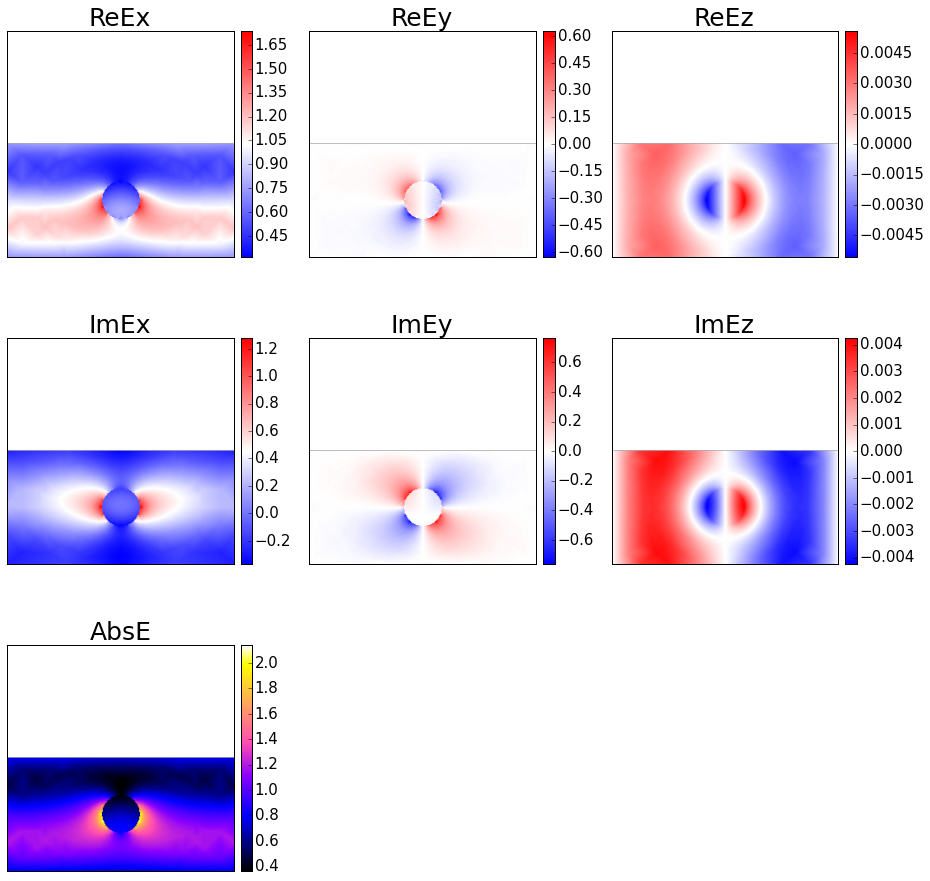

In [81]:
# field plots
plt.figure(figsize=(13,13))
for i_p,plot in enumerate(v_plots):
    ax = plt.subplot(3,3,i_p+1)
    if i_p==len(v_plots)-1:
        color='gnuplot2'
    else:
        color='bwr'
    im = plt.imshow(plot.T,cmap=color);
    
    # no ticks
    plt.xticks([])
    plt.yticks([])
    
    # titles
    plt.title(v_labels[i_p],fontsize=f_size)
    
    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=f_size-10) 
plt.tight_layout(1)